In [ ]:
import pandas as pd
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from torch.utils.data import TensorDataset
import time
nltk.download('punkt')
nltk.download('stopwords')
import re
from transformers import BertTokenizer, BertForSequenceClassification

import torch
from torch.utils.data import DataLoader

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Načítanie datasetov**

---


 train: Wikipedia dataset;
 test: Twitter dataset by Davidson (100%)

In [ ]:
test = pd.read_csv('all_data.csv')
train = pd.read_csv('wiki.csv')
train = train.drop('id', axis=1)
train = train.rename(columns={'comment_text': 'tweet'})
train = train.rename(columns={'toxic': 'class'})


In [ ]:
# Rozdelenie trénovacích dát na textové komentáre a zodpovedajúce triedy
train_texts = train['tweet']
train_labels = train['class']
test_texts = test['tweet']
test_labels = test['class']


In [ ]:
# Načítanie predtrénovanej BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Načítanie predtrénovanej BERT modelu pre klasifikáciu sekvencií
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenizácia textových komentárov a príprava dát pre trénovanie
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

# Vytvorenie trénovacieho datasetu z tokenizovaných dát
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(train_labels.tolist()))

# Vytvorenie testovacieho datasetu z tokenizovaných dát
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(test_labels.tolist()))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
try:
    # Trénovanie modelu
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    # Určenie zariadenia (GPU alebo CPU) na trénovanie modelu
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    model.train()

    # Definícia optimalizátora pre trénovanie modelu
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    # Trénovanie modelu počas 3 epoch
    for epoch in range(3):
        start_time = time.time()  # Uloženie času začiatku epochy
        print(f"Epócha {epoch + 1} z 3")
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
        end_time = time.time()  # Uloženie času konca epochy
        epoch_time = end_time - start_time  # Výpočet času stráveného na epóche
except Exception as e:
    # Spracovanie a výpis informácií o chybe, ak sa vyskytne
    print("Došlo k chybe:", e)


In [ ]:
# Testovanie modelu
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Prepínanie modelu do režimu vyhodnocovania
model.eval()

# Inicializácia premenných pre predikcie a skutočné triedy
all_preds = []
all_labels = []

for batch in test_loader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].cpu().numpy()
    # Výpočet predikcií modelu
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    # Zaznamenanie predikcií a skutočných tried
    all_preds.extend(preds)
    all_labels.extend(labels)

# Vyhodnotenie výsledkov
accuracy = accuracy_score(all_labels, all_preds)
print("Accuracy", accuracy)


Accuracy: 0.8217326393092039


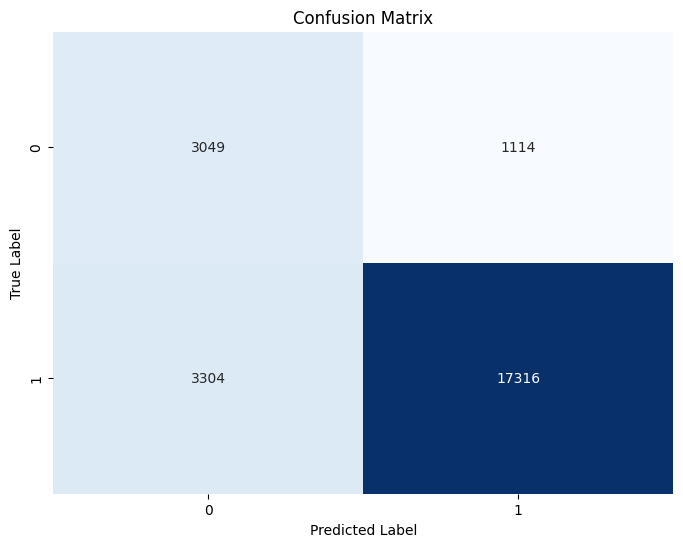

In [ ]:
# Výpočet confusion matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
def false_negative_rate(false_negatives, true_positives):
    return false_negatives / (false_negatives + true_positives)
# Vypočítanie falošných negatív
false_negatives = cm[1][0]
print(false_negatives)
# Vypočítanie počtu skutočných pozitív
true_positives = cm[1][1]
print(true_positives)
# Výpočet falošnej negatívnej miery
fnr = false_negative_rate(false_negatives, true_positives)

print("Falošná negatívna miera:", fnr)

3304
17316
Falošná negatívna miera: 0.16023278370514063
